# Conditional variable

In this example, we will demonstrate how to define a conditional variable. This is a variable which parameters depend on a value of another variable.

First, let's import the necessary packages:

In [1]:
from probabilistic_library import DistributionType, ReliabilityMethod, ReliabilityProject, ConditionalValue
import matplotlib.pyplot as plt


Consider a variable $h$ (kPa/m), which represents the pore water pressure in a clay layer of a levee. The variable follows a log-normal distribution, but its mean and standard deviation depend on the overtopping discharge $q$ (l/s/m), which varies per day. We assume the following relationships between the overtopping discharge $q$ and the mean and standard deviation of $h$:

Text(0, 0.5, 'Values (kPa/m)')

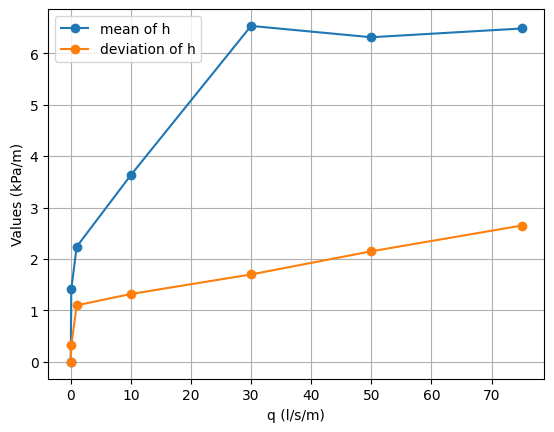

In [2]:
q = [0, 0.1, 1.0, 10.0, 30.0, 50.0, 75.0]
mu = [0, 1.42, 2.24, 3.63, 6.53, 6.31, 6.48]
sigma = [0, 0.32, 1.10, 1.32, 1.70, 2.15, 2.65]

plt.plot(q, mu, '-o', label="mean of h")
plt.plot(q, sigma, '-o', label="deviation of h")
plt.grid()
plt.legend()
plt.xlabel("q (l/s/m)")
plt.ylabel("Values (kPa/m)")

Let's assume that on a certain day the overtopping discharge $q$ is normally distributed with a mean of $50.0$ l/s/m and a standard deviation of $1.0$ l/s/m. The goal is to find the probability that the pore water pressure $h$ exceeds a level of $8.0$ kPa/m:
 
$\int P(h>8.0|q) \cdot f(q) dq$ and $q \sim N(50.0, 1.0)$

To compute this probability, we define the following limit state function, in which both $h$ and $q$ are included as inputs:

In [3]:
def pore_water_pressue(q, h, level):
    return level-h

Next, we define a reliability project that uses the above limit state function as its model:

In [4]:
project = ReliabilityProject()
project.model = pore_water_pressue

Then, we define the variable $q$ and the exceedance level:

In [5]:
project.variables["q"].distribution = DistributionType.normal
project.variables["q"].mean = 50.0
project.variables["q"].deviation = 1.0

project.variables["level"].distribution = DistributionType.deterministic
project.variables["level"].mean = 8.0

The conditional variable $h$ is defined as follows. It is necessary to specify the source of the variable - namely, the parameter $q$ - and to define the relationship between the values of $q$ and the parameters of $h$. In the case of a conditional variable, the distribution parameters will be interpolated between the grid points. When extrapolating, the first and last points from the grid will be used.

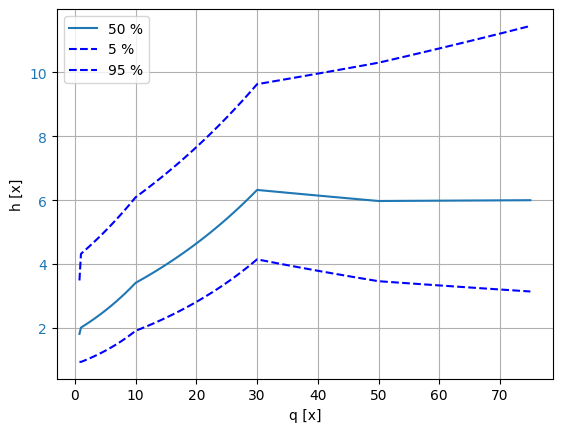

In [6]:
project.variables["h"].distribution = DistributionType.log_normal
project.variables["h"].mean = 0
project.variables["h"].deviation = 1
project.variables["h"].conditional = True
project.variables["h"].conditional_source = "q"

for ii in range(0, len(q)):
    conditional = ConditionalValue()
    conditional.x = q[ii]
    conditional.mean = mu[ii]
    conditional.deviation = sigma[ii]
    project.variables["h"].conditional_values.append(conditional)

project.variables["h"].plot_conditional()

We use the reliability method `form` and run the calculations.

In [7]:
project.settings.reliability_method = ReliabilityMethod.form

project.settings.relaxation_factor = 0.75
project.settings.maximum_iterations = 50
project.settings.variation_coefficient = 0.02

project.run()

The resulting probability is as follows:

In [8]:
project.design_point.print()

Reliability (FORM)
 Reliability index = 0.8816634355965782
 Probability of failure = 0.18897941982451144
 Convergence = 0.005252614689644438 (converged)
 Model runs = 15
Alpha values:
 q: alpha = -0.006893283320006563, x = 50.00607755585446
 h: alpha = -0.999976241040291, x = 7.999847989006122
 level: alpha = 0.0, x = 8.0



On a different day, when the distribution of $q$ is normal with a mean of $20.0$ and a standard deviation of $1.5$, the probability that the pore water pressure exceeds $8.0$ kPa/m becomes:

In [9]:
project.variables["q"].distribution = DistributionType.normal
project.variables["q"].mean = 20.0
project.variables["q"].deviation = 1.5

project.run()

project.design_point.print()

Reliability (FORM)
 Reliability index = 1.7774333771601072
 Probability of failure = 0.037748481637233156
 Convergence = 0.00429247981375467 (converged)
 Model runs = 12
Alpha values:
 q: alpha = -0.10777644330932801, x = 20.287348171414404
 h: alpha = -0.9941751547225425, x = 7.999766980891955
 level: alpha = 0.0, x = 8.0

